In [1]:
import sqlalchemy
import numpy as np
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from database_credentials import get_database_url

In [2]:
stop_words = set(stopwords.words('english'))
plt.style.use('ggplot')

In [3]:
def check_for_missing_data(data):
    """Print whether or not data contains missing data 
    along with the number of missing entries
    
    Args:
        data (dataframe): dataframe to be checked
        
    Returns:
        None
    """
    
    valid_mask = data.isnull()
    data_contains_missing_values = valid_mask.any().any()
    print("Contains missing values:", data_contains_missing_values)

    if (data_contains_missing_values):
        number_of_missing_values = valid_mask.sum().sum()
        print("Number of missing values:", number_of_missing_values)
    
def check_for_duplicate_ids(data):
    """Print whether or not data contains duplicate 
    Steam IDs along with the number of duplicates
    
    Args:
        data (dataframe): dataframe to be checked
        
    Returns:
        None
    """
    
    unique_id_mask = data['steam_id'].duplicated()
    data_contains_duplicates = unique_id_mask.any()
    print("\nContains duplicate Steam IDs:", data_contains_duplicates)

    if (data_contains_duplicates):
        number_of_duplicates = len(data[unique_id_mask])
        print("Number of duplicate Steam IDs:", number_of_duplicates)
        
def display_info(data):
    """Display the column names, number of rows, and information 
    regarding missing or duplicate values for a dataframe
    
    Args:
        data (dataframe): dataframe for which information will
                          be displayed
    Returns:
        None
    """
    
    print("Column Name and Types:\n{0}\n".format(data.dtypes))
    print("Number of rows: {0}\n".format(data.shape[0]))
    check_for_missing_data(data)
        
def mask_duplicate_ids(data):
    """Mask rows containing duplicate Steam IDs
    
    Args:
        data (dataframe): dataframe with duplicate Steam IDs

    Returns:
        masked_data (dataframe): a copy of data without duplicate
                                 Steam IDs
    """
    
    duplicate_id_mask = ~data['steam_id'].duplicated()
    masked_data = data[duplicate_id_mask]
    return masked_data

def get_review_rating(review):
    """Get the rating from review if applicable
    
    Args: 
        review (str): Steam review
        
    Returns:
        rating_numerator (float/None): rating within the review
    """
    
    rating_numerator = None
    match = re.search(r'(\d+(\.\d+)?)/10', review)
    if (match):
        rating = match[0]
        split_rating = rating.split('/')
        rating_numerator = float(split_rating[0])
        
    return rating_numerator

def graph_word_cloud(corpus):
    """Graph a word cloud based on corpus
    
    Args:
        corpus (str): contains the text data
    
    Returns:
        None
    """
    
    word_cloud = WordCloud(
        width=1600, height=800, 
        collocations=False
    ).generate(corpus)
    plt.figure(figsize=(20,20))
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    
def get_percentage_change(initial_value, final_value):
    change = (initial_value - final_value) / initial_value
    percentage_change = round(change * 100, 2)
    return percentage_change

def filter_tokens(tokens):
    filtered_tokens = [
        t for t in tokens if t not in (stop_words and string.punctuation)
    ]
    return filtered_tokens
    
def preprocess_review(review):
    lower_review = review.lower()
    preprocessed_review = word_tokenize(review.lower(), language='english')
    preprocessed_review = filter_tokens(preprocessed_review)
    return preprocessed_review

def initialize_term_df(vocab_list, label):
    term_df = pd.DataFrame(vocab_list, columns=['term'])
    term_df['label'] = label
    return term_df

def get_date_last_played_counts(data, column_name):
    date_boundaries = {
        'year_last_played': ("2013", "2019"),
        'year_month_last_played': ("2013-03", "2019-12")
    }
    boundaries = date_boundaries[column_name]
    
    date_last_played = data[column_name]
    date_last_played = date_last_played.value_counts()
    date_last_played = date_last_played.sort_index()
    
    date_last_played = date_last_played[
        (date_last_played.index >= boundaries[0]) &
        (date_last_played.index <= boundaries[1])
    ]
    return date_last_played

In [4]:
# connect to database
database_url = get_database_url()
engine = sqlalchemy.create_engine(database_url)
connection = engine.connect() 

In [5]:
# load data
review_query = '''
    SELECT 
        steam_id,
        user_review,
        FROM_UNIXTIME(timestamp_updated) AS timestamp_updated,
        recommends_game
    FROM reviews;
'''
review_data = pd.read_sql(review_query, connection)

user_query = '''
    SELECT 
        steam_id,
        CEIL(total_minutes_played / 60) AS total_hours_played,
        FROM_UNIXTIME(timestamp_last_played) AS datetime_last_played
    FROM users;
'''
user_data = pd.read_sql(user_query, connection)

I first start by getting an overview for the review and user data.

In [6]:
display(review_data.head(3))
display_info(review_data)
check_for_duplicate_ids(review_data)

,steam_id,user_review,timestamp_updated,recommends_game
0,76561198109804262,The Game is smooth with great graphics. It sho...,2015-01-14 08:40:12,1
1,76561198144109929,AMAZING Best thing ever. Great graphics for a ...,2015-01-14 06:02:29,1
2,76561198074106169,Best f2p game out there,2015-01-14 03:20:10,1


Column Name and Types:
steam_id                     object
user_review                  object
timestamp_updated    datetime64[ns]
recommends_game               int64
dtype: object

Number of rows: 149999

Contains missing values: False

Contains duplicate Steam IDs: True
Number of duplicate Steam IDs: 3


In [7]:
display(user_data.head(3))
display_info(user_data)
check_for_duplicate_ids(user_data)

earliest_last_played = user_data['datetime_last_played'].min()
print("\nEarliest last played:", earliest_last_played)

latest_last_played = user_data['datetime_last_played'].max()
print("Latest last played:", latest_last_played)

,steam_id,total_hours_played,datetime_last_played
0,76561198109804262,1007,2019-05-07 04:44:48
1,76561198144109929,157,2020-01-07 19:00:17
2,76561198074106169,238,2019-10-25 14:07:33


Column Name and Types:
steam_id                        object
total_hours_played               int64
datetime_last_played    datetime64[ns]
dtype: object

Number of rows: 149999

Contains missing values: False

Contains duplicate Steam IDs: True
Number of duplicate Steam IDs: 3

Earliest last played: 1969-12-31 16:00:00
Latest last played: 2020-03-01 11:49:39


The earliest last played dates indicates that there are issues regarding some of the data based on how Warframe was released in 2013 along with how 1969 is the Unix Epoch time.

In [8]:
epoch_data = (
    user_data[user_data['datetime_last_played'] == earliest_last_played]
)

display(epoch_data.head(1))

epoch_count = epoch_data.shape[0]
print("Epoch count:", epoch_count)

,steam_id,total_hours_played,datetime_last_played
2843,76561198092090794,0,1969-12-31 16:00:00


Epoch count: 11


The example user being the 2843<sup>rd</sup> to be fetched means that I need to check the 29<sup>th</sup> batch of data. Checking the 29<sup>th</sup> [batch](https://store.steampowered.com/appreviews/230410?json=1&language=english&day_range=9223372036854775807&num_per_page=100&purchase_type=all&cursor=AoIIQJ9c%2B3GM0h0%3D) of data and searching for **"last_played":0** shows that the problem lies with Steam. At this point I can either keep the data or mask it due to the size of my dataset. Based on how the datetimes will be filtered later on, I choose to keep the data as the rest of it can still be used.

Getting rid of duplicate Steam IDs using boolean masks and using a wordcloud to visualize the review data.

In [9]:
review_data = mask_duplicate_ids(review_data)
user_data = mask_duplicate_ids(user_data)

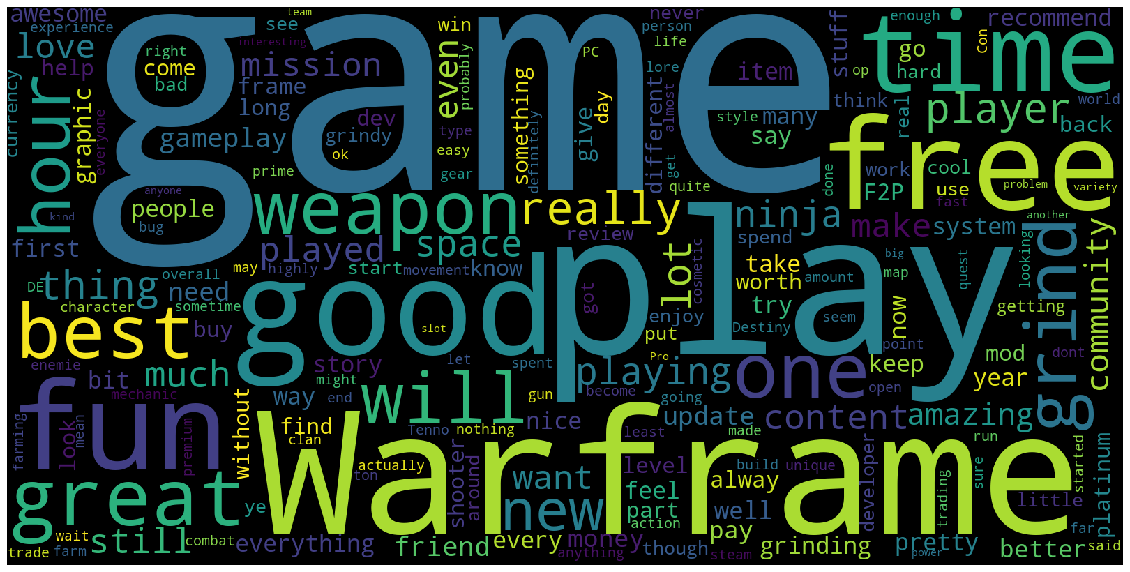

In [10]:
corpus_string = ' '.join(
    review_data.loc[review_data['recommends_game'] == True, 'user_review']
)
graph_word_cloud(corpus_string)

Moving on, I extract ratings (out of 10) from player reviews and discard those greater than 12. This retains 96% of the ratings while dealing with sparser and more extreme ratings.

In [11]:
ratings = review_data['user_review'].apply(get_review_rating)
ratings = ratings.dropna()
trimmed_ratings = ratings[ratings < 13]

In [12]:
number_ratings_initial = ratings.shape[0]
number_ratings_final = trimmed_ratings.shape[0]
percentage_ratings_trimmed = get_percentage_change(
    number_ratings_initial,
    number_ratings_final
)

print("Ratings before trimming:", number_ratings_initial)
print("Ratings after trimming:", number_ratings_final)
print("Percentage of ratings trimmed:", percentage_ratings_trimmed)

Ratings before trimming: 10357
Ratings after trimming: 9953
Percentage of ratings trimmed: 3.9


Display the review containing the most extreme outlier

In [13]:
outlier_index = ratings[np.isinf(ratings)].index[0]
review_data.loc[outlier_index, 'user_review']

'Best Game I have Played 2SPOOKY4ME 99999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999/10'

I then use the ratings as they are to create a violinplot and round the ratings to reduce the number of bins within the countplot.

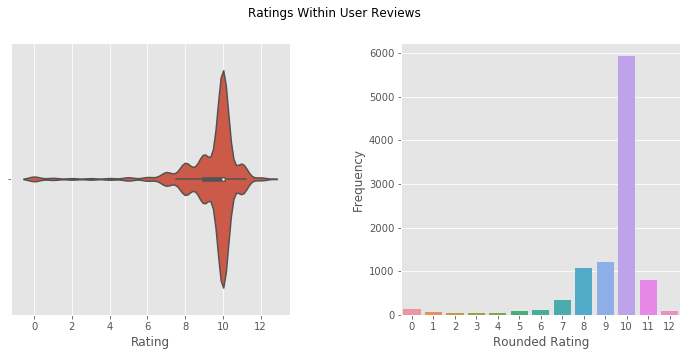

In [14]:
fig, axes = plt.subplots(
    nrows=1, 
    ncols=2, 
    figsize=(12, 5), 
    squeeze=False
)
plt.subplots_adjust(wspace=0.4)
axes = axes.flatten()

rating_violin = sns.violinplot(
    x=trimmed_ratings, 
    ax=axes[0]
)
rating_violin.set(xlabel="Rating")

rounded_ratings = trimmed_ratings.apply(lambda rating: round(rating, 0))
rating_bar = sns.countplot(
    x=rounded_ratings.astype(int),
    ax=axes[1]
)
rating_bar.set(xlabel="Rounded Rating", ylabel="Frequency")
plt.suptitle("Ratings Within User Reviews")
plt.show()

The violin plot determines ratings outside of the approximate interval [7, 11] as outliers
and shows the median of the ratings to be 10. Both the violin and bar plot show that the rating 10/10 appears most frequently and that ratings tend to be higher.

Preprocessing reviews by converting to lowercase, along with removing stopwords and punctuation.

In [15]:
review_data['preprocessed_review'] = (
    review_data['user_review'].apply(preprocess_review)
)

In [16]:
preprocessed_corpus = [
    ' '.join(review) for review in review_data['preprocessed_review']
]

In [17]:
instance_names = ["Fortuna", "Vallis", "Cetus", "Plains", "dojo", "relay"]
instances = initialize_term_df(instance_names, "instance")

warframe_names = [
    "Ash", "Atlas", "Banshee", "Baruuk", "Chroma", "Ember", "Equinox",
    "Excalibur", "Frost", "Gara", "Garuda", "Gauss", "Grendel", "Harrow",
    "Hildryn", "Hydroid", "Inaros", "Ivara", "Khora", "Limbo", "Loki",
    "Mag", "Mesa", "Mirage", "Nekros", "Nezha", "Nidus", "Nova", "Nyx",
    "Oberon", "Octavia", "Revenant", "Rhino", "Saryn", "Titania", "Trinity",
    "Valkyr", "Vauban", "Volt", "Wisp", "Wukong", "Zephyr"
]
warframes = initialize_term_df(warframe_names, "warframe")

enemy_names = ["Corpus", "Grineer", "Infested"]
enemies = initialize_term_df(enemy_names, "enemy")

npc_names = ["Lotus", "Clem", "Baro"]
npcs = initialize_term_df(npc_names, "npc")

# mission locations on the star chart
location_names = [
    "Mercury", "Venus", "Earth", "Mars", "Phobos",  
    "Ceres", "Void", "Jupiter", "Saturn", "Europa", 
    "Uranus", "Neptune", "Pluto", "Sedna", "Derelict"
]
locations = initialize_term_df(location_names, "location")

terms = [instances, warframes, enemies, npcs, locations]
term_data = pd.concat(terms)
term_data.reset_index(drop=True, inplace=True)

In [18]:
vocab = term_data['term'].str.lower()
pipe = Pipeline(
    [('count', CountVectorizer(vocabulary=vocab)),
     ('tfidf', TfidfTransformer())]
).fit(preprocessed_corpus)
X = pipe['count'].transform(preprocessed_corpus)
count_array = pd.DataFrame(X.toarray())
term_data['frequency'] = count_array.sum()
term_data['tfidf_score'] = pipe['tfidf'].idf_

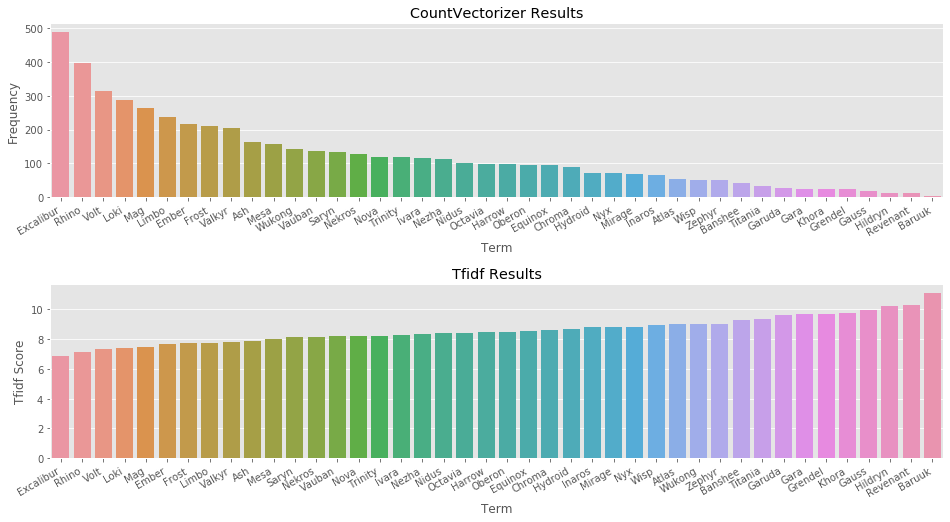

In [19]:
warframe_name_data = term_data[term_data['label'] == "warframe"]
warframe_name_sorted_frequency = (
    warframe_name_data.sort_values('frequency', ascending=False)
)
warframe_name_sorted_tfidf = (
    warframe_name_data.sort_values('tfidf_score', ascending=True)
)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))
plt.subplots_adjust(hspace=0.5)

axes = axes.flatten()
for axis in axes:
    plt.setp(axis.get_xticklabels(), rotation=30, ha="right")
    
warframe_frequency_bar = sns.barplot(
    x='term',
    y='frequency',
    data=warframe_name_sorted_frequency, ax=axes[0]
)
warframe_frequency_bar.set(
    title="CountVectorizer Results",
    xlabel="Term",
    ylabel="Frequency"
)

warframe_tfidf_bar = sns.barplot(
    x='term', 
    y='tfidf_score', 
    data=warframe_name_sorted_tfidf, 
    ax=axes[1]
)
warframe_tfidf_bar.set(
    title="Tfidf Results",
    xlabel="Term",
    ylabel="Tfidf Score"
)
plt.show()

After visualizing the results, we can see that the ranking for the first 5 and last 4 warframes are the same regardless of whether or not the count or tfidf score is used. On a side note, my favourite warframe Loki is ranked 4th. 

In [20]:
print("Highest ranked term for each category:")
for label in term_data['label'].unique():
    label_data = term_data[term_data['label'] == label]
    label_row = label_data['tfidf_score'].idxmin()
    print("{0}: {1}".format(label, label_data.loc[label_row, 'term']))

Highest ranked term for each category:
instance: Fortuna
warframe: Excalibur
enemy: Grineer
npc: Clem
location: Void


In [21]:
user_data['year_month_last_played'] = (
    user_data['datetime_last_played'].astype(str).apply(lambda dt: dt[0:7])
)
user_data['year_last_played'] = (
    user_data['datetime_last_played'].astype(str).apply(lambda dt: dt[0:4])
)

In [22]:
years_last_played = get_date_last_played_counts(user_data, 'year_last_played')
year_months_last_played = (
    get_date_last_played_counts(user_data, 'year_month_last_played')
)

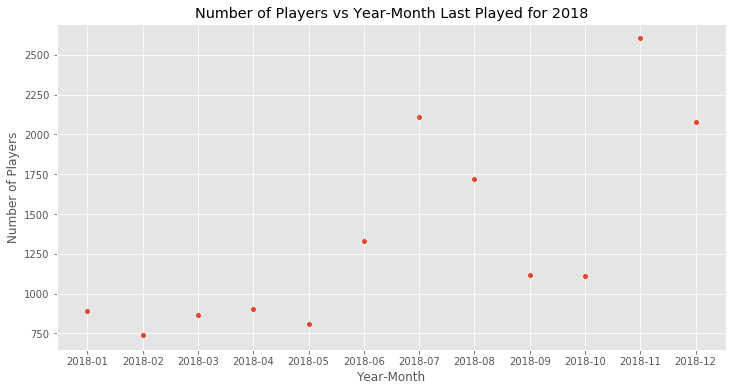

In [23]:
year = 2018 # change to view data for years ranging from [2013, 2019]
lower_bound = "{0}-01".format(year)
upper_bound = "{0}-12".format(year)

year_months_last_played_subset = year_months_last_played[
    (year_months_last_played.index >= lower_bound) &
    (year_months_last_played.index <= upper_bound)
]

plt.figure(figsize=(12, 6))
year_month_last_played_scatter = sns.scatterplot(
    data=year_months_last_played_subset, 
)
year_month_last_played_scatter.set(
    title="Number of Players vs Year-Month Last Played for {0}".format(year),
    xlabel="Year-Month",
    ylabel="Number of Players"
)
plt.show()

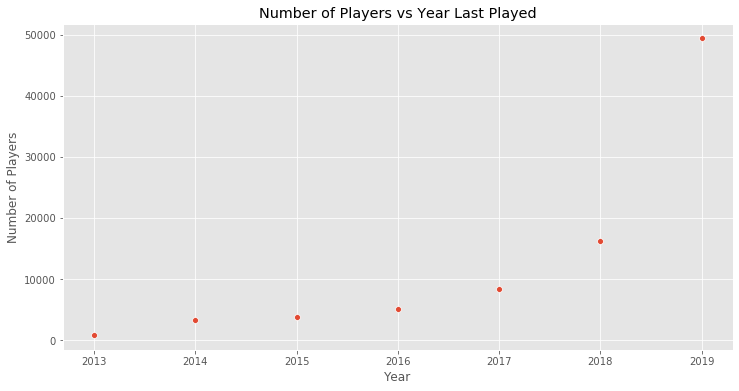

In [24]:
plt.figure(figsize=(12, 6))
year_last_played_scatter = sns.scatterplot(
    data=years_last_played
)
year_last_played_scatter.set(
    title='Number of Players vs Year Last Played',
    xlabel='Year',
    ylabel='Number of Players'
)
plt.show()

In [ ]:
connection.close()
engine.dispose()